In [2]:
import pandas as pd
import openpyxl
import h5py
import cv2
import numpy as np
import zarr
import os
import sys
sys.path.append('C:/Users/w37262do/Documents/git/PyIR/src')
from pyir_spectralcollection import PyIR_SpectralCollection as pir
import spectral_preprocessing as sp
from matplotlib import pyplot as plt
from scipy.ndimage import label, find_objects, binary_dilation
kit = pir()

In [3]:
qcl_path = r'D:/haolin_QCL_data/ZendTo-Cx8whJFBY4qKhpXy/ZendTo-Cx8whJFBY4qKhpXy/core3.zarr/core3.zarr'

imported_data = zarr.open(qcl_path)
stacked = np.stack(imported_data)

In [4]:
wav = wavenumber = np.load(r'D:/datasets/pcuk2023_qcl2025_whole_core_raw/wavenumbers.npy')
ydims = stacked.shape[0]
xdims = stacked.shape[1]
wav_dims = stacked.shape[2]

wavenumber_to_isolate = [1600, 1700]
positions =[0,0]
for i in np.arange(0,2):
    wax_pos = [np.where(wavenumber[:] <= wavenumber_to_isolate[i])[0][-1], np.where(wavenumber[:] >= wavenumber_to_isolate[i])[0][0]]
    if wax_pos[0]==wax_pos[1]:
        positions[i] = wax_pos[0]
    else:
        positions[i] = wax_pos[0]

amide_1 = positions
hypercube = np.reshape(stacked, (ydims*xdims, wav_dims))
am1 = hypercube[:, amide_1[0]:amide_1[1]] 
mins = np.min(am1,axis=1)
am1 = am1-mins[:, None]
am1_sum = np.sum(am1, axis=1)+0.01
tissue_filter = (am1_sum>2)

tissue_mask = (am1_sum>2).reshape(ydims, xdims)

hypercube = kit.all_spec_min2zero(hypercube)
hypercube = kit.vector_norm(hypercube)
hypercube, wavenumbers = kit.data_deriv(hypercube, wavenumber, 21, 5, 2) #todo

hypercube = np.reshape(hypercube, (ydims,xdims, len(wavenumbers)))

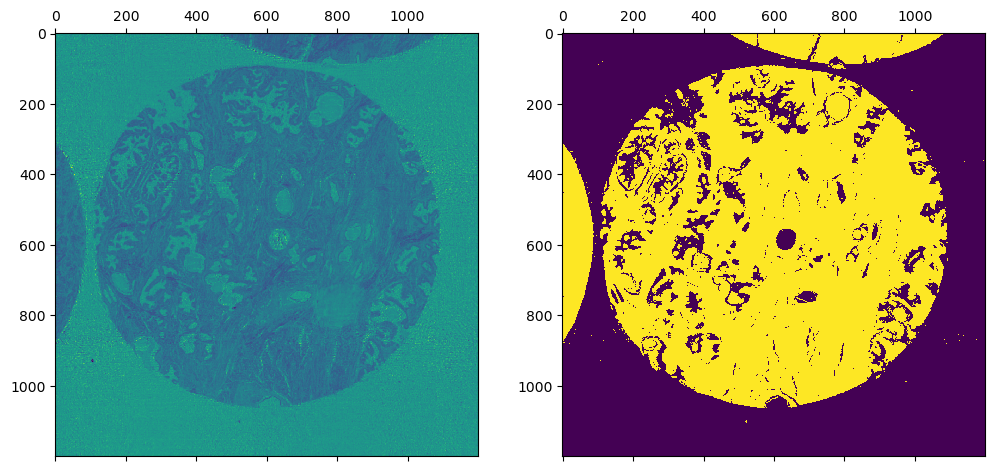

In [5]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].matshow(hypercube[...,340])
ax[1].matshow(tissue_mask)

In [6]:
import torch
from torch import nn

class PrintLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x.shape)
        return x

class LinearReduction(nn.Module):
    def __init__(self, input_dim, reduce_dim):
        super().__init__()
        self.reduce_dim = reduce_dim
        self.input_norm = nn.BatchNorm2d(input_dim)
        self.projection = nn.Conv2d(input_dim, reduce_dim, kernel_size=1, stride=1)
        self.projection_norm = nn.BatchNorm2d(reduce_dim)

    def forward(self, x):
        return self.projection_norm(self.projection(self.input_norm(x)))

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                          diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.print = PrintLayer()

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [7]:
model = nn.Sequential(
    LinearReduction(input_dim=405, reduce_dim=64),
    UNet(n_channels=64, n_classes=6),
)
#model_weights = torch.load(f"./models/unet_model_qcl_preprocess.pt", weights_only=True) # todo
model_weights = torch.load(f"./models/model_weights_3.pt", weights_only=True) # todo
with torch.no_grad():
    model.load_state_dict(model_weights)
model.eval()

Sequential(
  (0): LinearReduction(
    (input_norm): BatchNorm2d(405, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Conv2d(405, 64, kernel_size=(1, 1), stride=(1, 1))
    (projection_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): UNet(
    (print): PrintLayer()
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
       

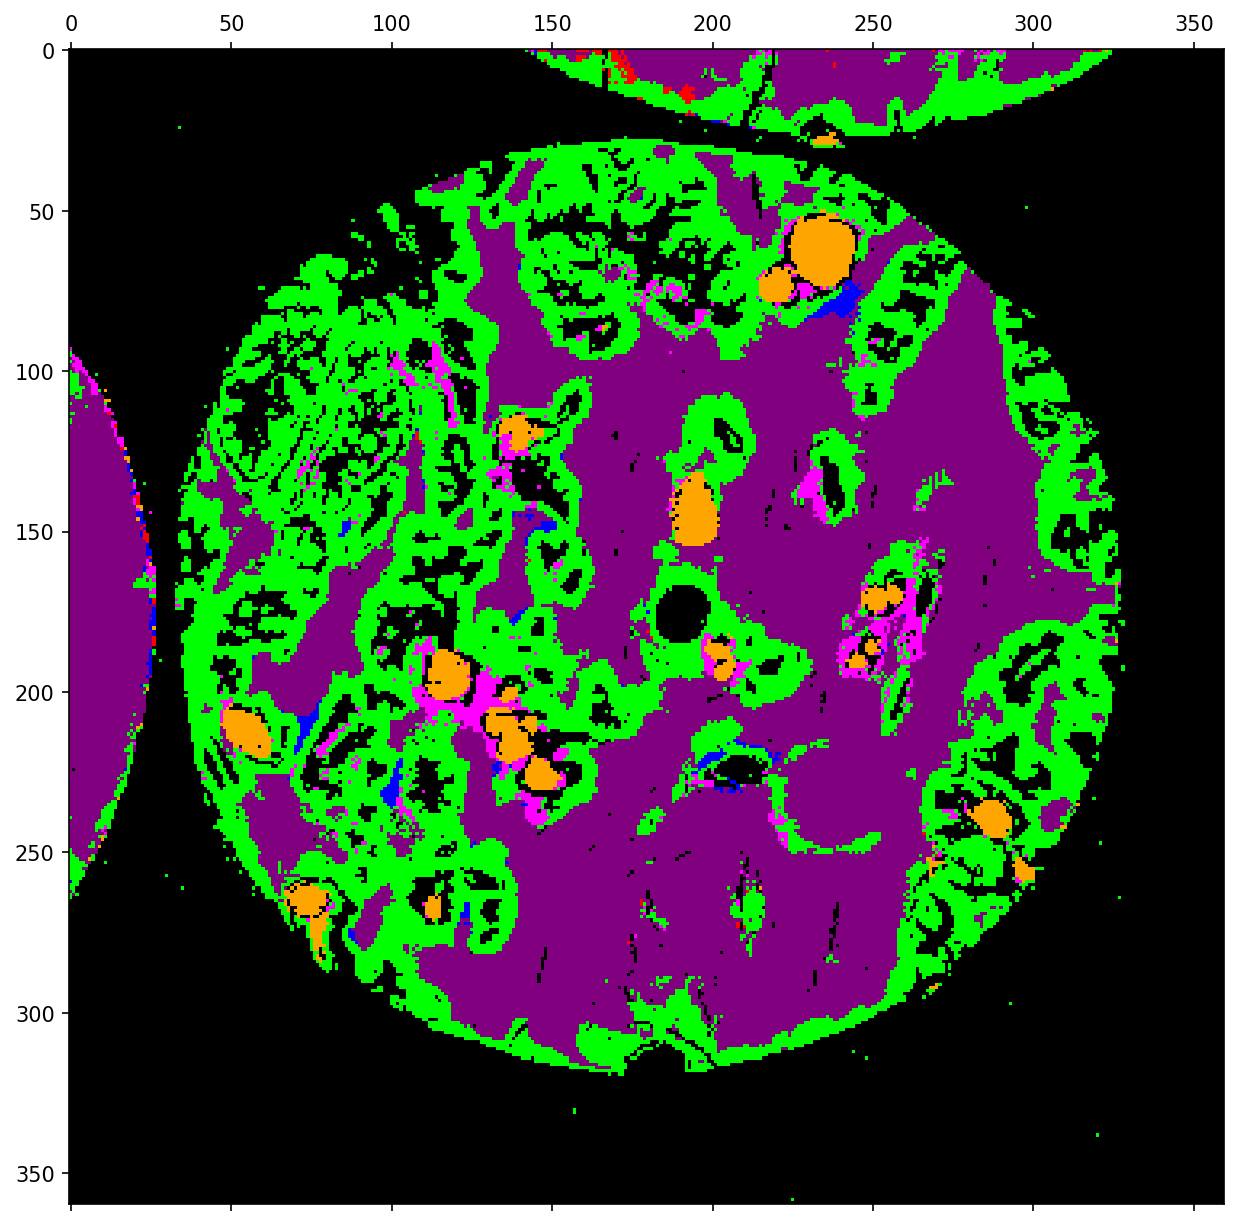

In [14]:
# Resize core
stacked_small = cv2.resize(hypercube, (360,360))

# Resize mask
mask_small = cv2.resize(tissue_mask.astype(np.uint8), (360,360), interpolation = cv2.INTER_NEAREST).astype(bool)#, interpolation=cv2.INTER_AREA)

# convert core array to core tensor
core_tensor = torch.from_numpy(stacked_small)

# push core tensor through model
with torch.no_grad():
    out = model(core_tensor.permute(2,0,1).unsqueeze(0))

# get predicted class for every pixel
predicted = out.squeeze().cpu().detach().numpy().argmax(axis=0)

# Show prediction
annotation_class_colors = np.array([[0, 255, 0], [128, 0, 128], [255, 0, 255], [0, 0, 255], [255, 165, 0], [255, 0, 0]])
annotation_class_names = np.array(['epithelium_n', 'stroma_n', 'epithelium_c', 'stroma_c', 'corpora_amylacea', 'blood'])
fig,ax = plt.subplots(figsize=(10,10),dpi=150)
ax.matshow(annotation_class_colors[predicted] * mask_small[:,:,None])

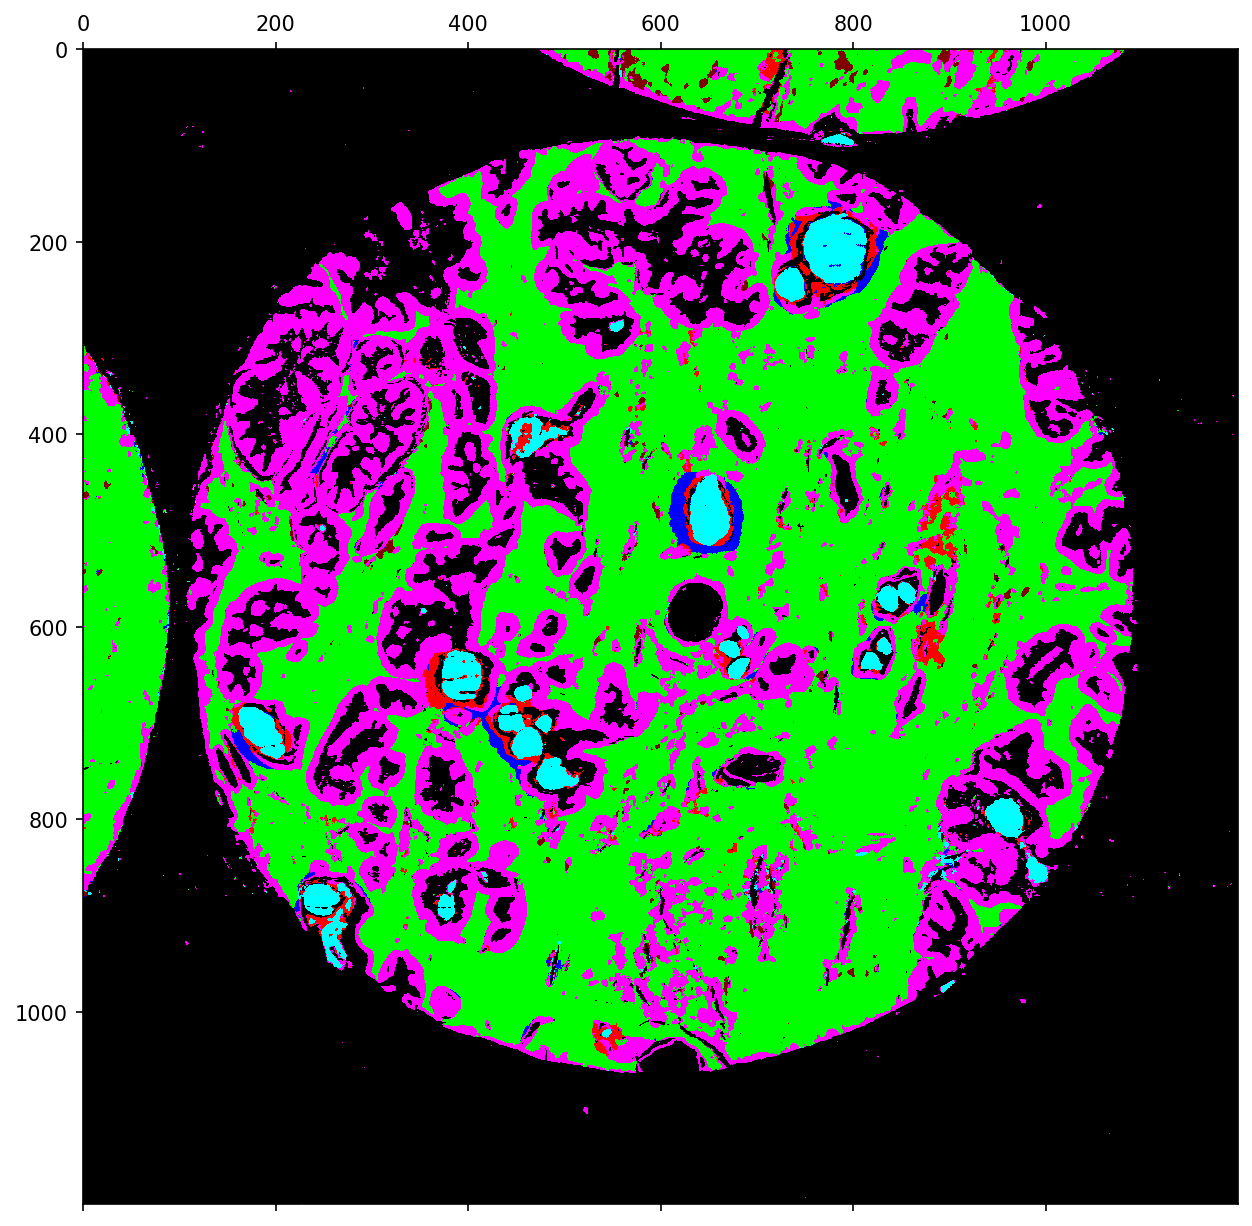

In [13]:
core_tensor = torch.from_numpy(hypercube)
with torch.no_grad():
    out = model(core_tensor.permute(2,0,1).unsqueeze(0))
pred_1 = out.squeeze().cpu().detach().numpy().argmax(axis=0)
#annotation_class_colors = np.array([[0, 255, 0], [128, 0, 128], [255, 0, 255], [0, 0, 255], [255, 165, 0], [255, 0, 0]])
annotation_class_colors = np.array([[255, 0, 255], [0, 255, 0], [255, 0, 0], [0, 0, 255], [0, 255, 255], [128, 0, 0]])
annotation_class_names = np.array(['epithelium_n', 'stroma_n', 'epithelium_c', 'stroma_c', 'corpora_amylacea', 'blood'])

fig,ax = plt.subplots(figsize=(10,10),dpi=150)
ax.matshow(annotation_class_colors[pred_1] * tissue_mask[:,:,None])

In [ ]:
core_tensor = torch.from_numpy(hypercube)
with torch.no_grad():
    out = model(core_tensor.permute(2,0,1).unsqueeze(0))
pred_1 = out.squeeze().cpu().detach().numpy().argmax(axis=0)

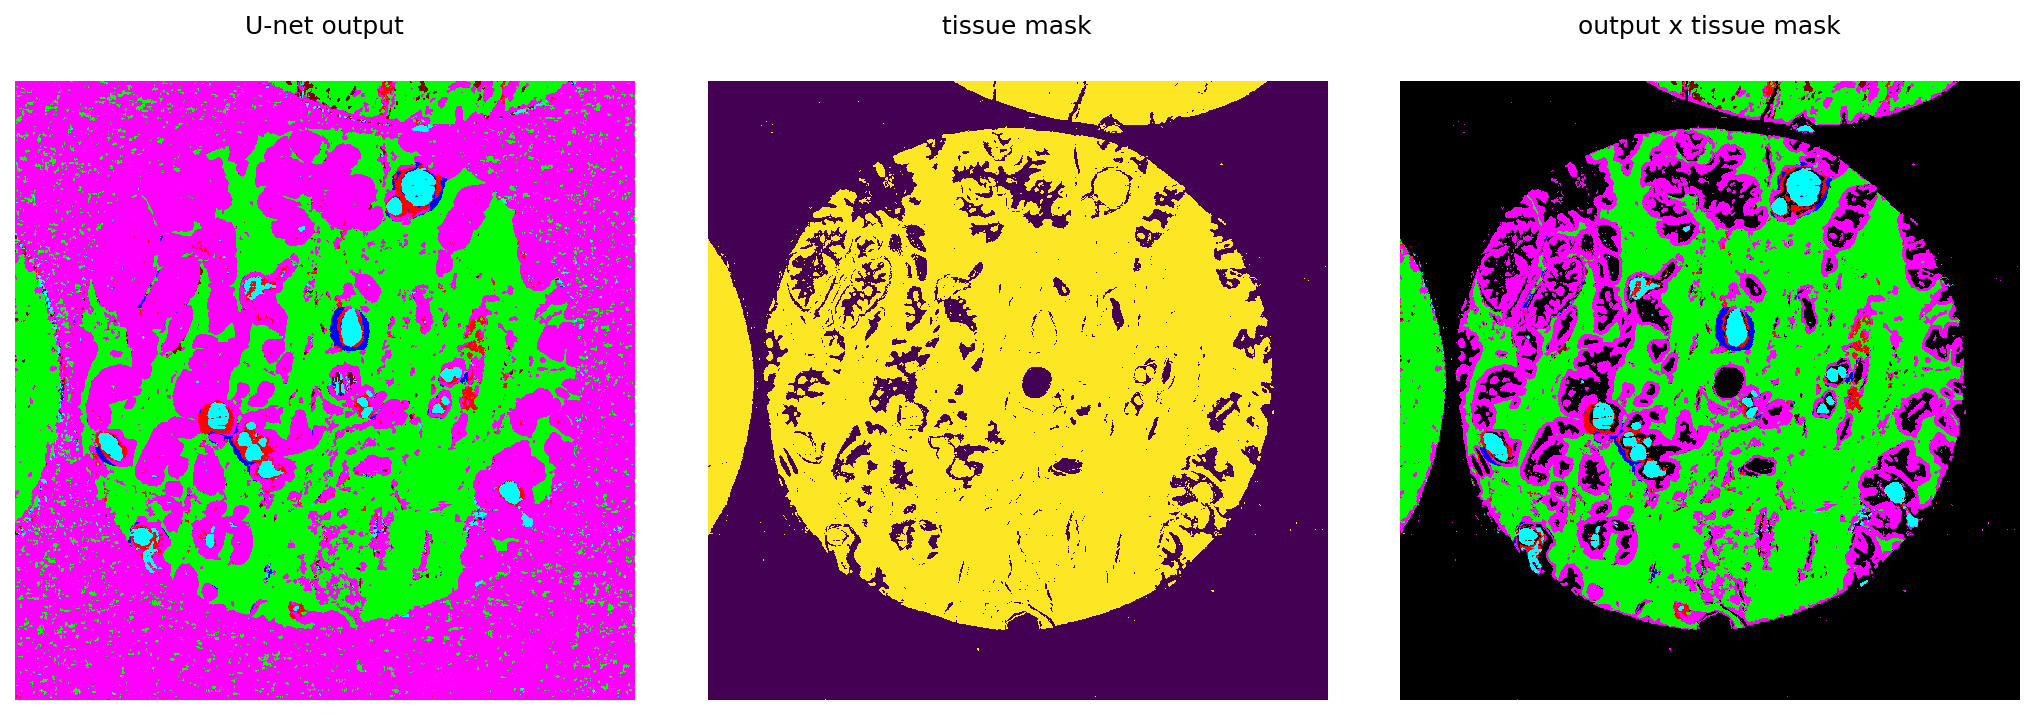

In [12]:

#annotation_class_colors = np.array([[0, 255, 0], [128, 0, 128], [255, 0, 255], [0, 0, 255], [255, 165, 0], [255, 0, 0]])
annotation_class_colors = np.array([[255, 0, 255], [0, 255, 0], [255, 0, 0], [0, 0, 255], [0, 255, 255], [128, 0, 0]])
annotation_class_names = np.array(['epithelium_n', 'stroma_n', 'epithelium_c', 'stroma_c', 'corpora_amylacea', 'blood'])

fig,ax = plt.subplots(1,3,figsize=(14,14/3),dpi=150)
ax[0].matshow(annotation_class_colors[pred_1]); ax[0].set_axis_off(); ax[0].set_title("U-net output")
ax[1].matshow(tissue_mask[:,:,None]); ax[1].set_axis_off(); ax[1].set_title("tissue mask")
ax[2].matshow(annotation_class_colors[pred_1] * tissue_mask[:,:,None]); ax[2].set_axis_off(); ax[2].set_title("output x tissue mask")
fig.tight_layout()

In [57]:
with torch.no_grad():
    out = model(core_tensor.permute(2,0,1).unsqueeze(0))

In [163]:
pred_1 = out.squeeze().cpu().detach().numpy().argmax(axis=0)

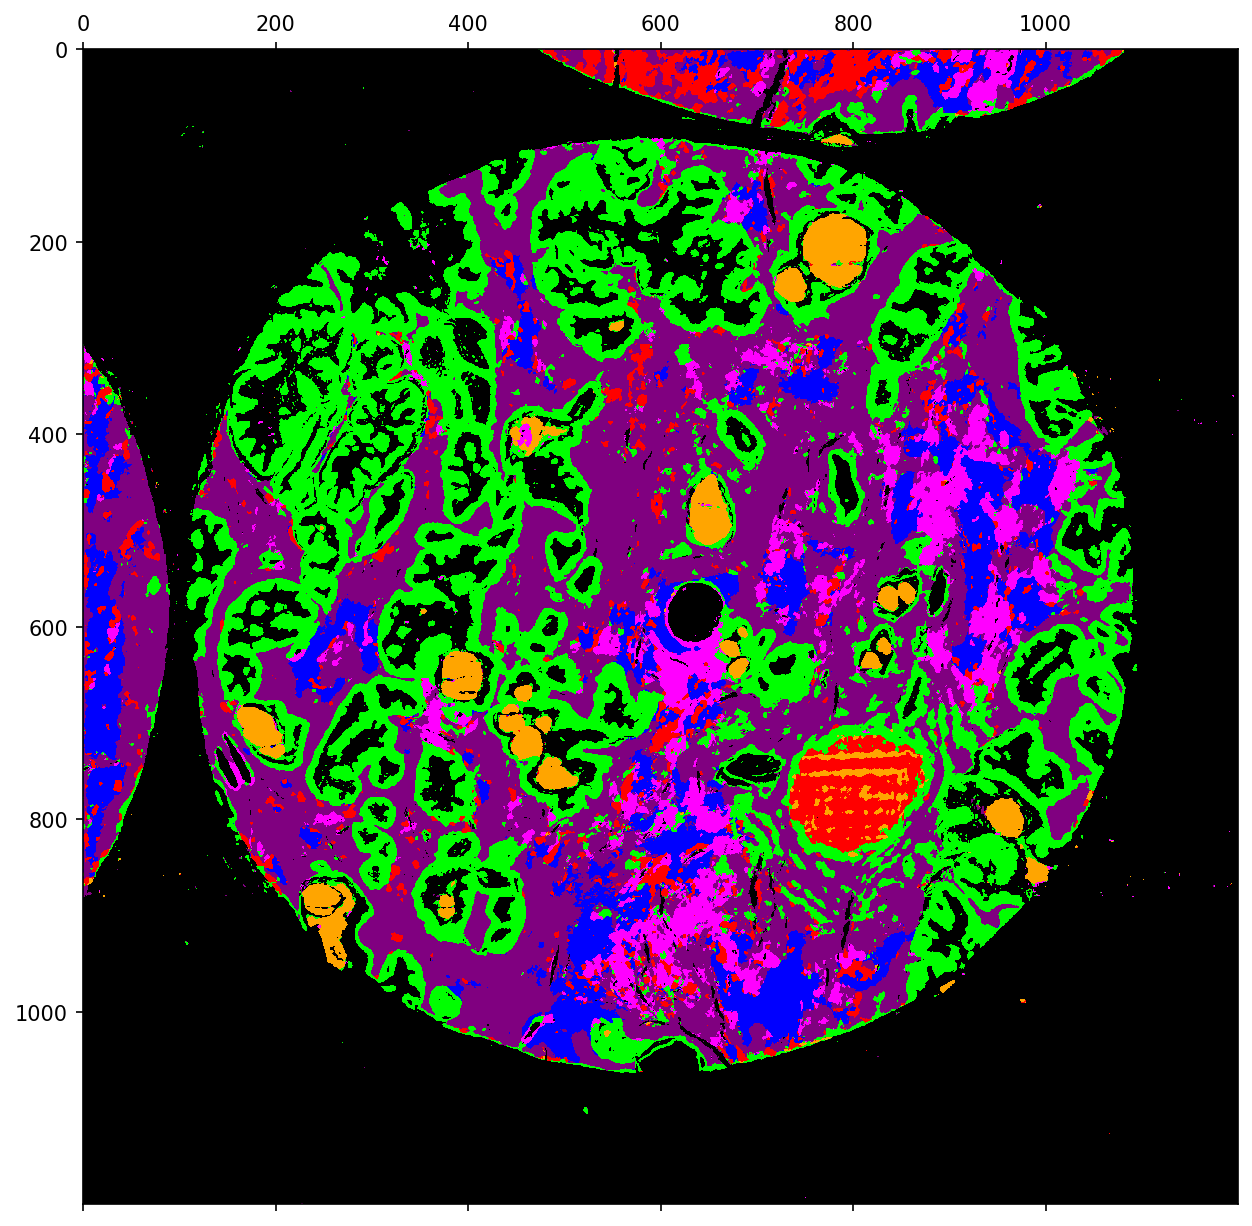

In [164]:
annotation_class_colors = np.array([[0, 255, 0], [128, 0, 128], [255, 0, 255], [0, 0, 255], [255, 165, 0], [255, 0, 0]])
#annotation_class_colors = np.array([[255, 0, 255], [0, 255, 0], [255, 0, 0], [0, 0, 255], [0, 255, 255], [128, 0, 0]])
annotation_class_names = np.array(['epithelium_n', 'stroma_n', 'epithelium_c', 'stroma_c', 'corpora_amylacea', 'blood'])

fig,ax = plt.subplots(figsize=(10,10),dpi=150)
ax.matshow(annotation_class_colors[pred_1] * tissue_mask[:,:,None])

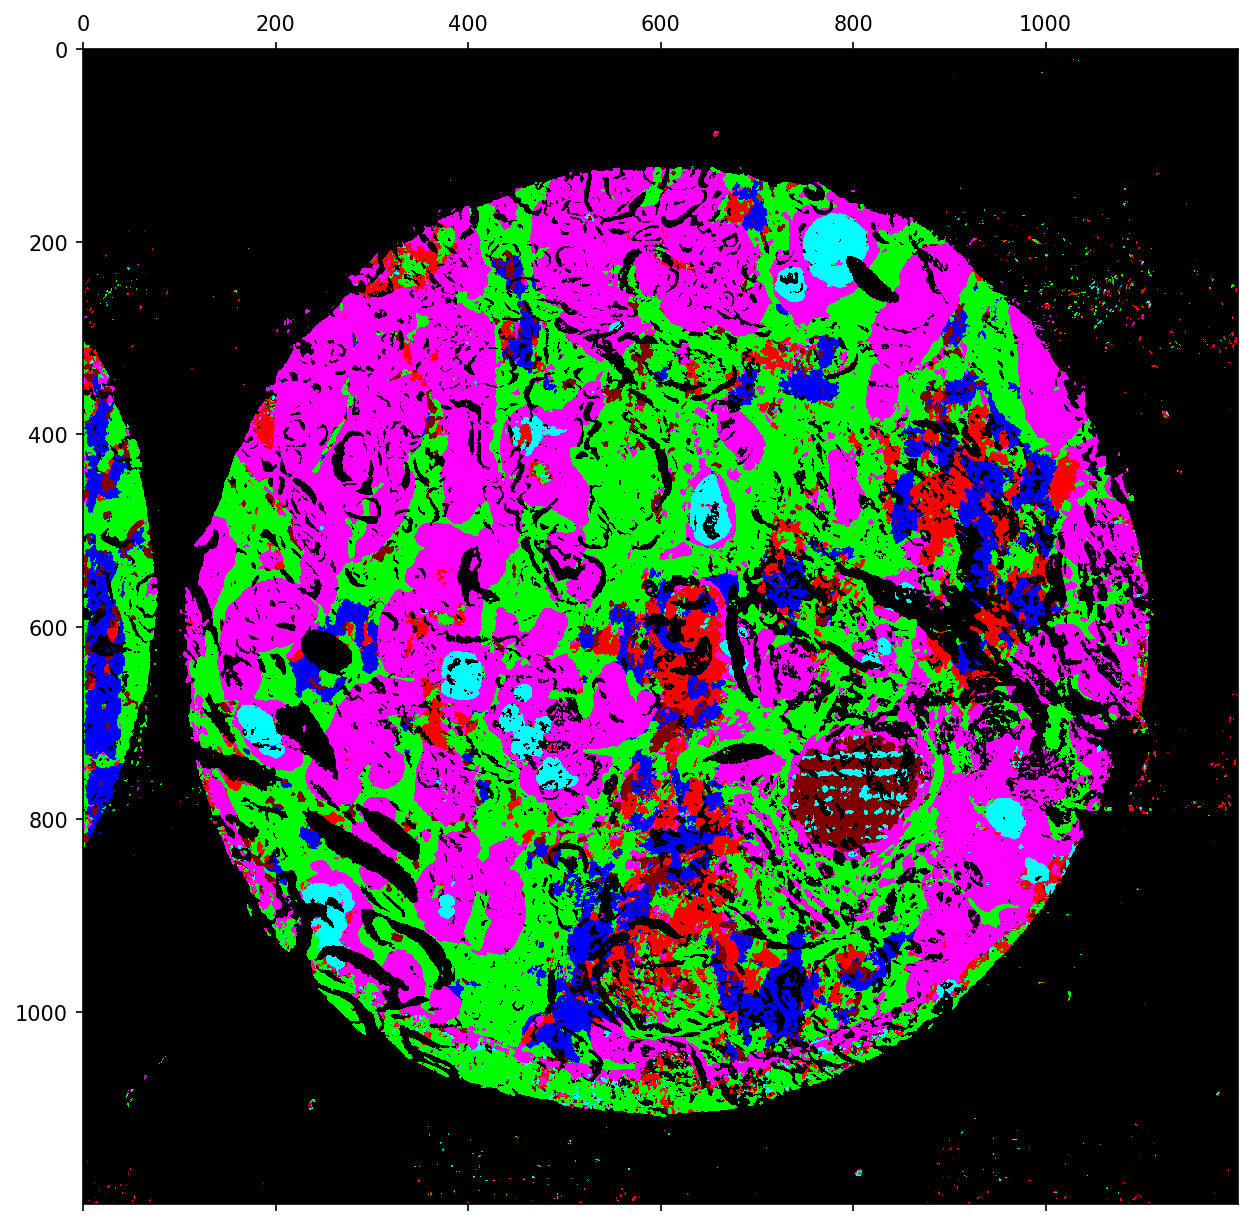

In [122]:
#annotation_class_colors = np.array([[0, 255, 0], [128, 0, 128], [255, 0, 255], [0, 0, 255], [255, 165, 0], [255, 0, 0]])
annotation_class_names = np.array(['epithelium_n', 'stroma_n', 'epithelium_c', 'stroma_c', 'corpora_amylacea', 'blood'])

fig,ax = plt.subplots(figsize=(10,10),dpi=150)
ax.matshow(annotation_class_colors[pred_0] * tissue_mask[:,:,None])